<a href="https://colab.research.google.com/github/wangbo6418/Google-Earth-Engine/blob/main/Koshi_GEE_02012026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Koshi channel belt paper. Main codes.

import ee
import geemap
import pandas as pd
#!pip -q install pycrs geopandas fiona shapely ipywidgets

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='the-dock-485715-s5')

In [ ]:
#from google.colab import files
#files.upload()


In [ ]:

aoi = ee.FeatureCollection("projects/the-dock-485715-s5/assets/koshi_aoi").geometry()
print("Area (km2):", aoi.area().divide(1e6).getInfo())



Area (km2): 349.5907190421468


In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 8)
Map.addLayer(ee.Image().paint(aoi, 1, 3), {"palette":["red"]}, "Manual channel belt (AOI)")
Map


Map(center=[26.554747768747283, 86.93741389345261], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
#1) Landsat collections (C2 L2 SR) + preprocessing

L5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
L8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
L9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

def mask_landsat_c2_l2(img):
    qa = img.select("QA_PIXEL")
    # mask: dilated cloud, cirrus, cloud, cloud shadow, snow
    dilated = qa.bitwiseAnd(1 << 1).neq(0)
    cirrus  = qa.bitwiseAnd(1 << 2).neq(0)
    cloud   = qa.bitwiseAnd(1 << 3).neq(0)
    shadow  = qa.bitwiseAnd(1 << 4).neq(0)
    snow    = qa.bitwiseAnd(1 << 5).neq(0)
    mask = dilated.Or(cirrus).Or(cloud).Or(shadow).Or(snow).Or(snow).Not()

    # scale SR bands to reflectance
    sr = img.select("SR_B.*").multiply(0.0000275).add(-0.2)
    return img.addBands(sr, overwrite=True).updateMask(mask).clip(aoi)

def rename_l5(img):
    # L5: B1 blue, B2 green, B3 red, B4 nir, B5 swir1, B7 swir2
    return img.select(
        ["SR_B1","SR_B2","SR_B3","SR_B4","SR_B5","SR_B7"],
        ["BLUE","GREEN","RED","NIR","SWIR1","SWIR2"]
    )

def rename_l89(img):
    # L8/9: B2 blue, B3 green, B4 red, B5 nir, B6 swir1, B7 swir2
    return img.select(
        ["SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7"],
        ["BLUE","GREEN","RED","NIR","SWIR1","SWIR2"]
    )

def add_indices(img):
    ndvi  = img.normalizedDifference(["NIR","RED"]).rename("NDVI")
    mndwi = img.normalizedDifference(["GREEN","SWIR1"]).rename("MNDWI")
    return img.addBands([ndvi, mndwi])


In [ ]:
#2) Annual composite (Dec–Mar)

def yearly_composite_dec_mar(year):
    year = int(year)
    start = ee.Date.fromYMD(year, 12, 1)
    end   = ee.Date.fromYMD(year + 1, 3, 31)

    if year <= 2012:
        col = (L5.filterBounds(aoi)
                 .filterDate(start, end)
                 .map(mask_landsat_c2_l2)
                 .map(rename_l5))
        scale = 30
    else:
        col = (L8.merge(L9)
                 .filterBounds(aoi)
                 .filterDate(start, end)
                 .map(mask_landsat_c2_l2)
                 .map(rename_l89))
        scale = 30

    col_size = col.size()

    # Fully masked placeholder with required reflectance bands + OBS
    empty = ee.Image(0).updateMask(ee.Image(0))
    base_placeholder = (empty.rename("BLUE")
        .addBands([
            empty.rename("GREEN"),
            empty.rename("RED"),
            empty.rename("NIR"),
            empty.rename("SWIR1"),
            empty.rename("SWIR2"),
            ee.Image(0).rename("OBS")
        ])
    )

    def build_nonempty_base():
        comp = ee.Image(col.median())
        obs  = ee.Image(col.select("NIR").count()).rename("OBS")
        comp = comp.updateMask(obs.gt(0)).addBands(obs)
        return comp

    base = ee.Image(ee.Algorithms.If(col_size.gt(0), build_nonempty_base(), base_placeholder))

    # ALWAYS add indices so NDVI/MNDWI exist even for empty years
    out = add_indices(base)

    return ee.Image(out).set({"year": year, "scale": scale, "n_images": col_size})





In [ ]:
#3) Classification (Water / Veg / Bare sandbars)

def classify_v1(img, mndwi_thr=0.10, ndvi_water_max=0.20, ndvi_veg_min=0.35, swir1_bare_min=0.05):
    img = ee.Image(img)

    ndvi  = img.select("NDVI")
    mndwi = img.select("MNDWI")
    swir1 = img.select("SWIR1")

    # Force-cast each mask to ee.Image
    water = ee.Image(mndwi.gt(mndwi_thr).And(ndvi.lt(ndvi_water_max))).rename("WATER")
    veg   = ee.Image(ndvi.gt(ndvi_veg_min).And(water.Not())).rename("VEG")
    bare  = ee.Image(ndvi.lt(ndvi_water_max).And(water.Not()).And(veg.Not()).And(swir1.gt(swir1_bare_min))).rename("BARE")

    # Build a guaranteed Image container and add bands
    cls = ee.Image(0).rename("DUMMY").addBands([water, veg, bare]).select(["WATER","VEG","BARE"])
    cls = cls.copyProperties(img, ["year", "scale"])
    return ee.Image(cls)   # <-- force cast on return



In [ ]:
#4) Area stats per year (km²) + table

def band_area_km2(mask_img, band_name, scale):
    mask_img = ee.Image(mask_img)  # force cast
    area_img = ee.Image.pixelArea().rename("area").updateMask(mask_img.select(band_name))

    s = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=ee.Number(scale),
        maxPixels=1e13
    ).get("area")

    return ee.Number(s).divide(1e6)

AOI_AREA_KM2 = 349.5  # km², fixed manual belt area

def summarize_year_py(year):
    img = ee.Image(yearly_composite_dec_mar(year))
    cls = ee.Image(classify_v1(img))

    water = band_area_km2(cls, "WATER", 30)
    veg   = band_area_km2(cls, "VEG",   30)
    bare  = band_area_km2(cls, "BARE",  30)
    active = water.add(bare)

    # ---- percentages of belt ----
    water_pct  = water.divide(AOI_AREA_KM2).multiply(100)
    veg_pct    = veg.divide(AOI_AREA_KM2).multiply(100)
    bare_pct   = bare.divide(AOI_AREA_KM2).multiply(100)
    active_pct = active.divide(AOI_AREA_KM2).multiply(100)

    return ee.Feature(None, {
        "year": year,
        "n_images": img.get("n_images"),

        # raw areas (km²)
        "water_km2": water,
        "veg_km2": veg,
        "bare_km2": bare,
        "active_km2": active,

        # normalized (% of belt)
        "water_pct": water_pct,
        "veg_pct": veg_pct,
        "bare_pct": bare_pct,
        "active_pct": active_pct
    })



In [ ]:
# Wrap results in ee.Image() to ensure they are treated as images, not generic Elements
img_test = ee.Image(yearly_composite_dec_mar(2020))
cls_test = ee.Image(classify_v1(img_test))

print("img_test type:", img_test.getInfo()["type"])
print("cls_test type:", cls_test.getInfo()["type"])
print("cls_test bands:", cls_test.bandNames().getInfo())

print("Water km2:", band_area_km2(cls_test, "WATER", 30).getInfo())
print("Veg km2:",   band_area_km2(cls_test, "VEG",   30).getInfo())
print("Bare km2:",  band_area_km2(cls_test, "BARE",  30).getInfo())

img_test type: Image
cls_test type: Image
cls_test bands: ['WATER', 'VEG', 'BARE']
Water km2: 42.73679176157992
Veg km2: 59.97309417715728
Bare km2: 146.8833296255419


In [ ]:
YEAR_PREVIEW = 2020

img = ee.Image(yearly_composite_dec_mar(YEAR_PREVIEW))
cls = ee.Image(classify_v1(img))

Map = geemap.Map()
Map.centerObject(aoi, 8)

# --- Landsat composite: True color (RGB) ---
rgb_vis = {"bands": ["RED", "GREEN", "BLUE"], "min": 0.0, "max": 0.3, "gamma": 1.2}
Map.addLayer(img, rgb_vis, f"Landsat RGB (Dec–Mar) {YEAR_PREVIEW}")

# --- Landsat composite: False color (NIR-Red-Green) ---
false_vis = {"bands": ["NIR", "RED", "GREEN"], "min": 0.0, "max": 0.35, "gamma": 1.2}
Map.addLayer(img, false_vis, f"Landsat False Color (NIR,R,G) {YEAR_PREVIEW}")

# --- Indices + classes ---
Map.addLayer(img.select("NDVI"), {"min": -0.2, "max": 0.8}, f"NDVI {YEAR_PREVIEW}")

Map.addLayer(cls.select("WATER").selfMask(), {"palette":["0000ff"]}, "Water")
Map.addLayer(cls.select("BARE").selfMask(),  {"palette":["f4d03f"]}, "Bare/Sand")
Map.addLayer(cls.select("VEG").selfMask(),   {"palette":["00aa00"]}, "Vegetation")

Map.addLayer(ee.Image().paint(aoi, 1, 2), {"palette":["red"]}, "AOI")

Map


Map(center=[26.554747768747283, 86.93741389345261], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
years = list(range(1985, 2026))
fc = ee.FeatureCollection([summarize_year_py(y) for y in years])

task = ee.batch.Export.table.toDrive(
    collection=fc,
    description="Koshi_DecMar_L5_L89_1985_2025_AreaTimeseries_withPct",
    fileFormat="CSV"
)
task.start()

print("Export started.")





Export started.


In [2]:
from google.colab import drive
drive.mount("/content/drive")


csv_path = "/content/drive/MyDrive/Koshi_DecMar_L5_L89_1985_2025_AreaTimeseries_withPct.csv"
df = pd.read_csv(csv_path)
df.head()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,system:index,active_km2,active_pct,bare_km2,bare_pct,n_images,veg_km2,veg_pct,water_km2,water_pct,year,.geo
0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1985,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1986,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,212.698674,60.857990,167.479888,47.919853,11,24.832915,7.105269,45.218786,12.938136,1987,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3,235.193063,67.294153,185.344250,53.031259,7,34.387229,9.838978,49.848813,14.262894,1988,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4,251.502639,71.960698,207.018193,59.232673,16,7.259510,2.077113,44.484447,12.728025,1989,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [3]:
dfp = df[df["n_images"] >= 3].copy()

dfp[["year", "n_images"]].head()

,year,n_images
2,1987,11
3,1988,7
4,1989,16
5,1990,10
6,1991,8


In [4]:
#!pip -q install statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess

# dfp should already exist and include: year, water_pct, bare_pct, veg_pct, active_pct
FRAC = 0.30  # smoothness; try 0.25–0.40

for col in ["active_pct", "bare_pct", "veg_pct", "water_pct"]:
    dfp[col + "_loess"] = lowess(dfp[col].values, dfp["year"].values, frac=FRAC, return_sorted=False)
dfp[["year","active_pct","active_pct_loess"]].head()


,year,active_pct,active_pct_loess
2,1987,60.857990,67.586426
3,1988,67.294153,67.661493
4,1989,71.960698,67.469027
5,1990,72.675496,67.144624
6,1991,72.423145,66.819437


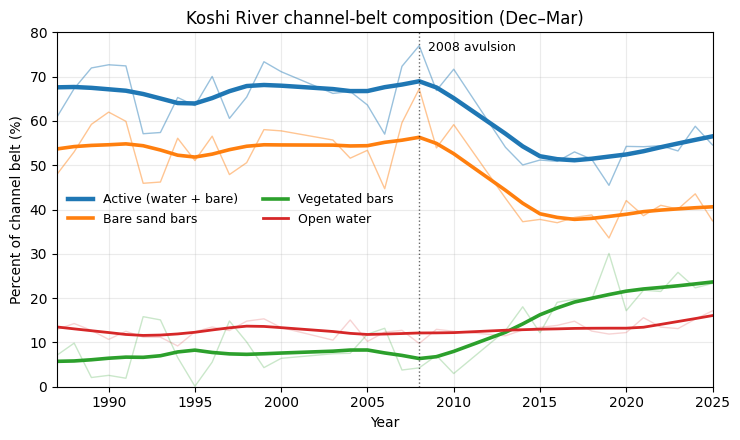

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7.5, 4.5))

# Raw annual (thin)
plt.plot(dfp["year"], dfp["active_pct"], color="#1f77b4", alpha=0.45, lw=1)
plt.plot(dfp["year"], dfp["bare_pct"],   color="#ff7f0e", alpha=0.45, lw=1)
plt.plot(dfp["year"], dfp["veg_pct"],    color="#2ca02c", alpha=0.25, lw=1)
plt.plot(dfp["year"], dfp["water_pct"],  color="#d62728", alpha=0.20, lw=1)

# LOESS (thick)
plt.plot(dfp["year"], dfp["active_pct_loess"], color="#1f77b4", lw=3.2, label="Active (water + bare)")
plt.plot(dfp["year"], dfp["bare_pct_loess"],   color="#ff7f0e", lw=2.6, label="Bare sand bars")
plt.plot(dfp["year"], dfp["veg_pct_loess"],    color="#2ca02c", lw=2.6, label="Vegetated bars")
plt.plot(dfp["year"], dfp["water_pct_loess"],  color="#d62728", lw=2.0, label="Open water")

# Optional avulsion marker
plt.axvline(2008, color="k", lw=1, ls=":", alpha=0.6)
plt.text(2008.5, 78, "2008 avulsion", fontsize=9, va="top")

plt.xlabel("Year")
plt.ylabel("Percent of channel belt (%)")
plt.title("Koshi River channel-belt composition (Dec–Mar)", fontsize=12)
plt.ylim(0, 80)
plt.xlim(dfp["year"].min(), dfp["year"].max())
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, ncol=2, fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import ee, geemap

def preview_map(year):
    img = ee.Image(yearly_composite_dec_mar(year))
    cls = ee.Image(classify_v1(img))

    Map = geemap.Map()
    Map.centerObject(aoi, 8)

    # False color: NIR, RED, GREEN (great for bars/veg)
    false_vis = {"bands": ["NIR","RED","GREEN"], "min": 0.0, "max": 0.35, "gamma": 1.2}
    Map.addLayer(img, false_vis, f"False color (Dec–Mar) {year}")

    # Optional overlays (semi-transparent)
    Map.addLayer(cls.select("WATER").selfMask(), {"palette":["0000ff"]}, "Water")
    Map.addLayer(cls.select("BARE").selfMask(),  {"palette":["f4d03f"]}, "Bare/Sand")
    Map.addLayer(cls.select("VEG").selfMask(),   {"palette":["00aa00"]}, "Vegetation")

    # AOI outline
    Map.addLayer(ee.Image().paint(aoi, 1, 2), {"palette":["ff0000"]}, "AOI")

    return Map

# Example preview
preview_map(2008)


Map(center=[26.554747768747283, 86.93741389345261], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
YEAR_PREVIEW = 2020

img = ee.Image(yearly_composite_dec_mar(YEAR_PREVIEW))

Map = geemap.Map()
Map.centerObject(aoi, 8)

# --- Landsat false color: 7-5-2 (SWIR2, NIR, Blue) ---
vis_752 = {
    "bands": ["SWIR2", "NIR", "BLUE"],
    "min": 0.02,
    "max": 0.35,
    "gamma": 1.1
}

Map.addLayer(img, vis_752, f"Landsat 7-5-2 (Veg=Green, Water=Blue) {YEAR_PREVIEW}")

# Optional: AOI outline
Map.addLayer(ee.Image().paint(aoi, 1, 2), {"palette":["red"]}, "AOI")

Map



Map(center=[26.554747768747283, 86.93741389345261], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import os, requests, ee

out_dir = "/content/drive/MyDrive/Koshi"
os.makedirs(out_dir, exist_ok=True)


def export_752_AOIshape_tiff_fixed(year, scale=30):
    img = ee.Image(yearly_composite_dec_mar(year))

    vis_752 = {
        "bands": ["SWIR2", "NIR", "BLUE"],
        "min": [0.02, 0.03, 0.02],
        "max": [0.30, 0.45, 0.25],
        "gamma": [1.1, 1.05, 1.15]
    }

    out = img.visualize(**vis_752).clip(aoi)

    params = {
        "region": aoi,
        "scale": scale,
        "format": "GEO_TIFF"
    }

    url = out.getDownloadURL(params)
    out_path = f"{out_dir}/Koshi_752_AOIshape_fixed_{year}.tif"

    r = requests.get(url)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)

    print("Saved:", out_path)


In [ ]:
for yr in [2007, 2010, 2015, 2025]:
    #export_falsecolor_752_AOIshape_jpeg(yr)
    export_752_AOIshape_tiff_fixed(yr)


Saved: /content/drive/MyDrive/Koshi/Koshi_752_AOIshape_fixed_2007.tif
Saved: /content/drive/MyDrive/Koshi/Koshi_752_AOIshape_fixed_2010.tif
Saved: /content/drive/MyDrive/Koshi/Koshi_752_AOIshape_fixed_2015.tif
Saved: /content/drive/MyDrive/Koshi/Koshi_752_AOIshape_fixed_2025.tif


In [ ]:
import os, requests, ee

out_dir = "/content/drive/MyDrive/Koshi"
os.makedirs(out_dir, exist_ok=True)

def export_432_AOIshape_tiff_and_jpg(year, scale=30):
    img = ee.Image(yearly_composite_dec_mar(year))

    # True color 4-3-2 (your band aliases: RED, GREEN, BLUE)
    vis_432 = {
        "bands": ["RED", "GREEN", "BLUE"],
        "min": [0.02, 0.02, 0.02],
        "max": [0.30, 0.30, 0.30],
        "gamma": [1.1, 1.1, 1.1]
    }

    out = img.visualize(**vis_432).clip(aoi)

    # ---- GeoTIFF ----
    tiff_params = {"region": aoi, "scale": scale, "format": "GEO_TIFF"}
    tiff_url = out.getDownloadURL(tiff_params)
    tiff_path = f"{out_dir}/Koshi_432_AOIshape_{year}.tif"

    r = requests.get(tiff_url); r.raise_for_status()
    with open(tiff_path, "wb") as f:
        f.write(r.content)
    print("Saved TIFF:", tiff_path)

    # ---- JPEG preview ----
    jpg_params = {"region": aoi, "scale": scale, "format": "jpg"}
    jpg_url = out.getThumbURL(jpg_params)
    jpg_path = f"{out_dir}/Koshi_432_AOIshape_{year}.jpg"

    r = requests.get(jpg_url); r.raise_for_status()
    with open(jpg_path, "wb") as f:
        f.write(r.content)
    print("Saved JPG:", jpg_path)


In [ ]:
for yr in [2007, 2010, 2015, 2025]:
    export_432_AOIshape_tiff_and_jpg(yr, scale=30)


Saved TIFF: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2007.tif
Saved JPG: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2007.jpg
Saved TIFF: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2010.tif
Saved JPG: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2010.jpg
Saved TIFF: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2015.tif
Saved JPG: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2015.jpg
Saved TIFF: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2025.tif
Saved JPG: /content/drive/MyDrive/Koshi/Koshi_432_AOIshape_2025.jpg


In [ ]:
# change movement concentration calculation below this cell.

In [ ]:
import ee

PROJ_30 = ee.Projection("EPSG:32645").atScale(30)

def water_concentration_grid(year, cell=300):
    year = int(year)
    img = ee.Image(yearly_composite_dec_mar(year))
    n_images = ee.Number(img.get("n_images"))

    # Safe output for empty years
    empty = ee.Feature(None, {
        "year": year, "n_images": n_images, "cell_m": cell,
        "water_km2": 0, "dominant_cell_share": 0, "Neff_cells": 0, "n_cells": 0
    })

    def nonempty():
        cls = ee.Image(classify_v1(img))

        # 0/1 water at 30m in fixed projection
        water01 = (cls.select("WATER")
                   .unmask(0).toFloat()
                   .setDefaultProjection(PROJ_30))

        # Cell water fraction (0–1): mean of 30m water01 in each cell
        wf = (water01
              .reduceResolution(ee.Reducer.mean(), bestEffort=True)
              .setDefaultProjection(ee.Projection("EPSG:32645").atScale(cell)))

        # Mask to cells with any water (wf > 0)
        wf_pos = wf.updateMask(wf.gt(0))

        # Total water area (km2) using 30 m water mask (more accurate)
        water_km2 = ee.Number(
            ee.Image.pixelArea().updateMask(water01).reduceRegion(
                ee.Reducer.sum(), aoi, 30, maxPixels=1e13
            ).get("area")
        ).divide(1e6)

        # Sum of cell weights
        w_sum = ee.Number(
            wf_pos.reduceRegion(ee.Reducer.sum(), aoi, cell, maxPixels=1e13
            ).get("WATER")
        )

        # Max cell weight
        w_max = ee.Number(
            wf_pos.reduceRegion(ee.Reducer.max(), aoi, cell, maxPixels=1e13
            ).get("WATER")
        )

        # Neff over cells: 1 / sum(p_i^2)
        # We compute sum(w^2) then divide by (sum w)^2
        w2_sum = ee.Number(
            wf_pos.pow(2).reduceRegion(ee.Reducer.sum(), aoi, cell, maxPixels=1e13
            ).get("WATER")
        )

        neff = ee.Number(0)
        dom = ee.Number(0)

        neff = ee.Algorithms.If(w_sum.gt(0),
                                ee.Number(1).divide(w2_sum.divide(w_sum.pow(2))),
                                0)
        dom  = ee.Algorithms.If(w_sum.gt(0),
                                w_max.divide(w_sum),
                                0)

        n_cells = ee.Number(
            wf_pos.reduceRegion(ee.Reducer.count(), aoi, cell, maxPixels=1e13
            ).get("WATER")
        )

        return ee.Feature(None, {
            "year": year,
            "n_images": n_images,
            "cell_m": cell,
            "water_km2": water_km2,
            "dominant_cell_share": dom,
            "Neff_cells": neff,
            "n_cells": n_cells
        })

    return ee.Feature(ee.Algorithms.If(n_images.gt(0), nonempty(), empty))


In [ ]:
years = list(range(1985, 2026))
fc = ee.FeatureCollection([water_concentration_grid(y, cell=300) for y in years])

task = ee.batch.Export.table.toDrive(
    collection=fc,
    description="Koshi_DecMar_WaterConcentration_GRID_1985_2025",
    fileFormat="CSV"
)
task.start()
print("Export started.")



Export started.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dfc = pd.read_csv("/content/drive/MyDrive/Koshi_DecMar_WaterConcentration_GRID_1985_2025.csv")

# Keep only years with data
dfc = dfc[dfc["n_images"] >= 3]

# Sort by year
dfc = dfc.sort_values("year")





In [ ]:
import matplotlib.pyplot as plt

# Match the style you used for the boxplot figure
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "savefig.bbox": "tight",
})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_neff_timeseries(
    dfc,
    year_col="year",
    y_col="Neff_cells",
    avulsion_year=2008,
    figsize=(6.5, 4),
    out_png=None,
    out_pdf=None,
    dpi=400
):
    d = dfc[[year_col, y_col]].dropna().sort_values(year_col)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(d[year_col], d[y_col], color="black", lw=2)

    # Avulsion line
    ax.axvline(avulsion_year, color="red", ls="--", lw=1)

    # Annotation: inside axes, consistent size, no overlap
    y0, y1 = ax.get_ylim()
    y_text = y1 - 0.08 * (y1 - y0)
    ax.text(
        avulsion_year + 0.4, y_text, "2008 avulsion",
        color="red", fontsize=10, va="top"
    )

    ax.set_ylabel("Effective number of wetted cells (Neff)")
    ax.set_xlabel("Year")
    ax.grid(alpha=0.2)
    ax.set_title("Neff")

    fig.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=dpi)
    if out_pdf:
        fig.savefig(out_pdf)  # vector

    return fig, ax


In [ ]:
def plot_domshare_timeseries(
    dfc,
    year_col="year",
    y_col="dominant_cell_share",
    avulsion_year=2008,
    figsize=(6.5, 4),
    out_png=None,
    out_pdf=None,
    dpi=400
):
    d = dfc[[year_col, y_col]].dropna().sort_values(year_col)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(d[year_col], d[y_col], lw=2)  # default color ok, matches your prior plot

    ax.axvline(avulsion_year, color="red", ls="--", lw=1)

    y0, y1 = ax.get_ylim()
    y_text = y1 - 0.08 * (y1 - y0)
    ax.text(
        avulsion_year + 0.4, y_text, "2008 avulsion",
        color="red", fontsize=10, va="top"
    )

    ax.set_ylabel("Dominant wetted-cell share")
    ax.set_xlabel("Year")
    ax.grid(alpha=0.2)
    ax.set_title("Dominant wetted-cell share")

    fig.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=dpi)
    if out_pdf:
        fig.savefig(out_pdf)

    return fig, ax


(<Figure size 650x400 with 1 Axes>,
 <Axes: title={'center': 'Dominant wetted-cell share'}, xlabel='Year', ylabel='Dominant wetted-cell share'>)

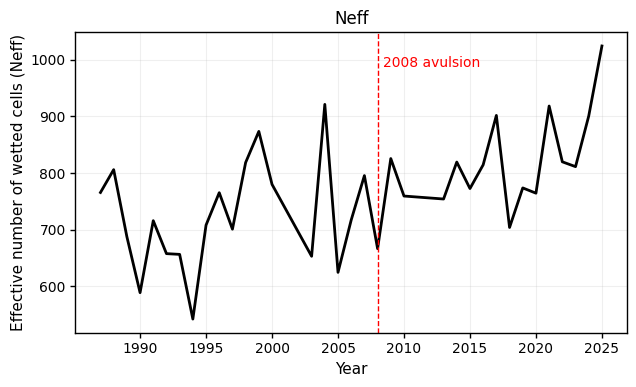

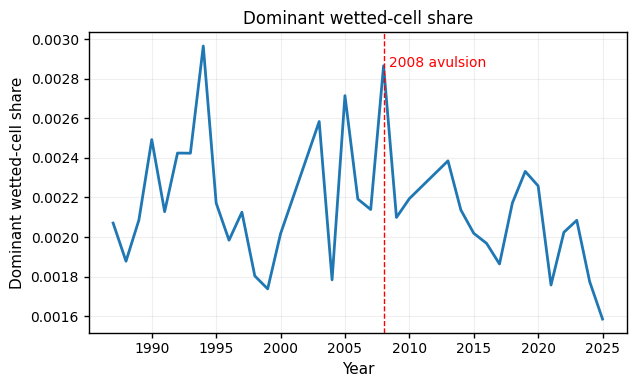

In [ ]:
out_dir = "/content/drive/MyDrive/Koshi"

plot_neff_timeseries(
    dfc,
    out_png=f"{out_dir}/Fig_Neff_timeseries.png",
    #out_pdf=f"{out_dir}/Fig_Neff_timeseries.pdf"
)

plot_domshare_timeseries(
    dfc,
    out_png=f"{out_dir}/Fig_DominantShare_timeseries.png",
    #out_pdf=f"{out_dir}/Fig_DominantShare_timeseries.pdf"
)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Plot style (journal-friendly)
# ----------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "savefig.bbox": "tight",
})

def _jitter(x, amount=0.08, seed=0):
    rng = np.random.default_rng(seed)
    return x + rng.uniform(-amount, amount, size=len(x))

def _median_iqr(a):
    a = np.asarray(a)
    a = a[np.isfinite(a)]
    if len(a) == 0:
        return np.nan, np.nan, np.nan
    q25, med, q75 = np.percentile(a, [25, 50, 75])
    return med, q25, q75

def plot_pre_post_two_panel(
    df,                      # pandas DataFrame
    group_col="period",      # values: "Pre-2008", "Post-2008"
    left_col="Neff_cells",
    right_col="dominant_cell_share",
    left_ylabel="Neff (flow dispersion)",
    right_ylabel="Dominant wetted-cell share",
    order=("Pre-2008", "Post-2008"),   # match your current figure order
    out_png=None,
    out_pdf=None,
    dpi=400
):
    # clean inputs
    d = df[[group_col, left_col, right_col]].copy()
    d = d[d[group_col].isin(order)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    for ax, col, ylabel, title_seed in zip(
        axes,
        [left_col, right_col],
        [left_ylabel, right_ylabel],
        [1, 2]
    ):
        data = [d.loc[d[group_col] == g, col].dropna().values for g in order]
        ns = [len(x) for x in data]

        # boxplot (median/IQR)
        bp = ax.boxplot(
            data,
            labels=list(order),
            widths=0.35,
            patch_artist=True,
            showfliers=True,
            medianprops=dict(linewidth=1.6),
            whiskerprops=dict(linewidth=1.2),
            capprops=dict(linewidth=1.2),
            boxprops=dict(linewidth=1.2),
        )
        for b in bp["boxes"]:
            b.set_alpha(0.15)

        # scatter overlay (jittered)
        for i, y in enumerate(data, start=1):
            x = _jitter(np.full(len(y), i), seed=title_seed*10 + i)
            ax.scatter(x, y, s=18, alpha=0.65, linewidths=0)

        # axis labels
        ax.set_ylabel(ylabel)
        ax.grid(axis="y", alpha=0.25)

        # annotate n + median (IQR)
        y_all = np.concatenate([x for x in data if len(x) > 0]) if any(ns) else np.array([0])
        y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)
        pad = (y_max - y_min) * 0.10 if y_max > y_min else 1.0
        #y_text = y_max + pad
        y_text = y_max - pad * 0.10



        ax.set_ylim(y_min - pad*0.2, y_text + pad*0.15)

    # titles (short)
    axes[0].set_title("(a) Neff")
    axes[1].set_title("(b) Dominant wetted-cell share")


    if out_png:
        fig.savefig(out_png, dpi=dpi, transparent=False)
    if out_pdf:
        fig.savefig(out_pdf)  # vector
    return fig, axes


In [ ]:
plot_pre_post_two_panel(
    dfc,
    group_col="period",
    left_col="Neff_cells",
    right_col="dominant_cell_share",
    out_png="Fig_PrePost_Neff_DomShare.png",
    out_pdf="Fig_PrePost_Neff_DomShare.pdf"
)


KeyError: "['period'] not in index"